##Описание датасета

25 тысяч отзывов фильмов с сайта IMDB с метками положительных и
отрицательных отзывов. Каждый отзыв закодирован в виде списка из
индексов слов. Сами слова проиндексированы по частоте встречания в
отзывах.

##Код

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. Устанавливаем unrar для работы с .rar архивами
!apt-get install -y unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
import os

# Укажите путь к вашему архиву dataImdb.rar в Google Drive
archive_path = '/content/drive/MyDrive/dataImdb.rar'  # измените если нужно

# Проверим существует ли архив
if os.path.exists(archive_path):
    print("Архив найден!")

    # Создаем папку для распаковки
    !mkdir -p /content/data

    # Распаковываем архив
    !unrar x "{archive_path}" /content/data/

    print("Архив успешно распакован!")
else:
    print("Архив не найден! Проверьте путь.")

    # Посмотрим что есть в корне Drive
    print("Содержимое корня Drive:")
    print(os.listdir('/content/drive/MyDrive'))

All OK
Архив успешно распакован!


In [ ]:
# 4. Проверяем структуру распакованных данных
data_dir = '/content/data/dataImdb'
print("Содержимое папки /content/data/dataImdb:")
print(os.listdir(data_dir))

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print(f"\nTrain directory: {os.listdir(train_dir)}")
print(f"Test directory: {os.listdir(test_dir)}")

# Посчитаем количество файлов
def count_files(folder):
    neg_path = os.path.join(folder, 'neg')
    pos_path = os.path.join(folder, 'pos')

    neg_count = len([f for f in os.listdir(neg_path) if f.endswith('.txt')])
    pos_count = len([f for f in os.listdir(pos_path) if f.endswith('.txt')])

    return neg_count, pos_count

train_neg, train_pos = count_files(train_dir)
test_neg, test_pos = count_files(test_dir)

print(f"\nТренировочные данные: {train_neg} негативных, {train_pos} позитивных")
print(f"Тестовые данные: {test_neg} негативных, {test_pos} позитивных")

Содержимое папки /content/data/dataImdb:
['train', '.DS_Store', 'test']

Train directory: ['pos', 'neg', '.DS_Store', 'urls_neg.txt', 'urls_pos.txt']
Test directory: ['pos', 'neg', '.DS_Store', 'urls_neg.txt', 'urls_pos.txt']

Тренировочные данные: 12500 негативных, 12500 позитивных
Тестовые данные: 12500 негативных, 12500 позитивных


In [ ]:
# 5. Загружаем и предобрабатываем данные
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def load_texts_labels(folder):
    texts = []
    labels = []
    for label_type in ['neg', 'pos']:
        dir_name = os.path.join(folder, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                try:
                    with open(os.path.join(dir_name, fname), 'r', encoding='utf-8') as f:
                        texts.append(f.read())
                    labels.append(1 if label_type == 'pos' else 0)
                except:
                    # Если UTF-8 не работает, пробуем другие кодировки
                    try:
                        with open(os.path.join(dir_name, fname), 'r', encoding='latin-1') as f:
                            texts.append(f.read())
                        labels.append(1 if label_type == 'pos' else 0)
                    except Exception as e:
                        print(f"Ошибка чтения файла {fname}: {e}")
    return texts, labels

print("Загружаем тренировочные данные...")
train_texts, train_labels = load_texts_labels(train_dir)
print("Загружаем тестовые данные...")
test_texts, test_labels = load_texts_labels(test_dir)

print(f"Загружено {len(train_texts)} тренировочных отзывов")
print(f"Загружено {len(test_texts)} тестовых отзывов")

# Токенизация и преобразование в последовательности
max_words = 10000
maxlen = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

X_train = tokenizer.texts_to_sequences(train_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

y_train = np.asarray(train_labels)
y_test = np.asarray(test_labels)

print(f"Размерность X_train: {X_train.shape}")
print(f"Размерность X_test: {X_test.shape}")

Загружаем тренировочные данные...
Загружаем тестовые данные...
Загружено 25000 тренировочных отзывов
Загружено 25000 тестовых отзывов
Размерность X_train: (25000, 200)
Размерность X_test: (25000, 200)


In [ ]:
# 6. Создаем модель согласно варианту 20
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='tanh'))      # Первый скрытый слой
model.add(Dense(16, activation='tanh'))      # Второй скрытый слой
model.add(Dense(1, activation='sigmoid'))    # Выходной слой

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',  # Среднеабсолютная погрешность
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 7. Обучаем модель
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6269 - loss: 0.3801 - val_accuracy: 0.0000e+00 - val_loss: 0.9997
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6203 - loss: 0.3797 - val_accuracy: 0.0000e+00 - val_loss: 0.9998
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6333 - loss: 0.3669 - val_accuracy: 0.2416 - val_loss: 0.7582
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7149 - loss: 0.2850 - val_accuracy: 0.6924 - val_loss: 0.3079
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8237 - loss: 0.1766 - val_accuracy: 0.6490 - val_loss: 0.3509
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8432 - loss: 0.1574 - val_accuracy: 0.7308 - val_loss: 0.2691
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8558 - loss: 0.1442 - val_accuracy: 0.7174 - val_loss: 0.2828
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8706 - loss: 0.1293

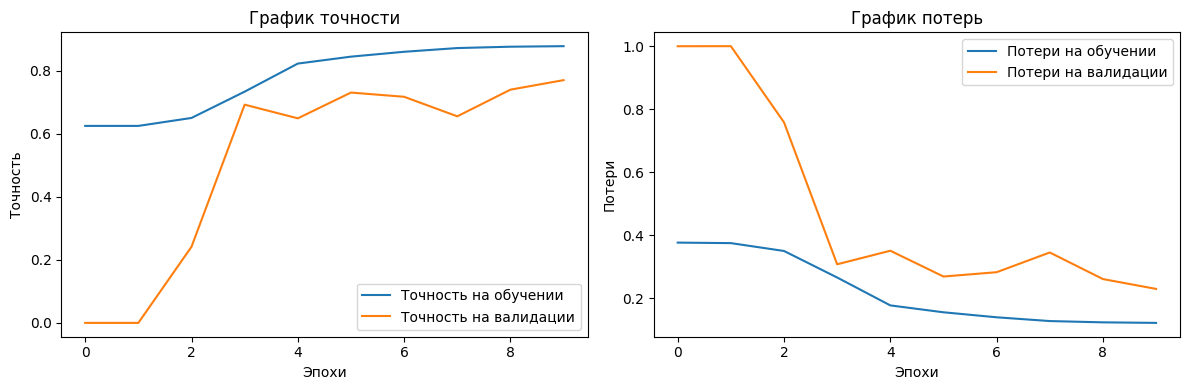

In [ ]:
# 8. Визуализируем результаты
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Точность на обучении')
plt.plot(history.history['val_accuracy'], label='Точность на валидации')
plt.title('График точности')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Потери на обучении')
plt.plot(history.history['val_loss'], label='Потери на валидации')
plt.title('График потерь')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 9. Оцениваем модель на тестовых данных
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Точность на тестовых данных: {test_acc:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8515 - loss: 0.1481
Точность на тестовых данных: 0.8167


In [ ]:
# 10. Сравниваем с базовой моделью
base_model = Sequential()
base_model.add(Embedding(max_words, 32, input_length=maxlen))
base_model.add(Flatten())
base_model.add(Dense(16, activation='relu'))
base_model.add(Dense(16, activation='relu'))
base_model.add(Dense(1, activation='sigmoid'))

base_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

base_history = base_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

base_test_loss, base_test_acc = base_model.evaluate(X_test, y_test, verbose=0)

print("\n" + "="*50)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
print("="*50)
print(f"Ваша модель (2 слоя, 64-16, tanh-tanh, MAE): {test_acc:.4f}")
print(f"Базовая модель (2 слоя, 16-16, relu-relu, BCE): {base_test_acc:.4f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7021 - loss: 0.5465 - val_accuracy: 0.8318 - val_loss: 0.3954
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9443 - loss: 0.1524 - val_accuracy: 0.8148 - val_loss: 0.4631
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9940 - loss: 0.0256 - val_accuracy: 0.7764 - val_loss: 0.7572
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9995 - loss: 0.0044 - val_accuracy: 0.7834 - val_loss: 0.9995
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 1.0000 - loss: 6.0222e-04 - val_accuracy: 0.6958 - val_loss: 1.5870
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 1.0000 - loss: 5.6079e-04 - val_accuracy: 0.8036 - val_loss: 1.0093
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 1.0000 - loss: 8.2352e-05 - val_accuracy: 0.7918 - val_loss: 1.1530
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 1.0000 - loss: 3.8846e

In [ ]:
# Выводим 55-й отрицательный отзыв из тренировочной выборки
review_index = 55  # 55-й отзыв (индексация с 0)

negative_review = train_texts[review_index]
true_label = train_labels[review_index]  # Должно быть 0 для отрицательного отзыва

print(f"55-й отрицательный отзыв (первые 200 символов):\n{negative_review[:200]}...")
print(f"Истинная метка: {true_label}")

# Преобразуем этот отзыв в формат для модели
review_sequence = tokenizer.texts_to_sequences([negative_review])  # Оборачиваем в список!
review_padded = pad_sequences(review_sequence, maxlen=maxlen)

# Делаем предсказание
prediction = model.predict(review_padded)
prediction_prob = prediction[0][0]  # Берем первое (и единственное) предсказание

print(f"\n=== РЕЗУЛЬТАТ ПРЕДСКАЗАНИЯ ===")
print(f"Выход нейронной сети: {prediction_prob:.4f}")

# Интерпретируем результат
if prediction_prob > 0.5:
    sentiment = "ПОЛОЖИТЕЛЬНЫЙ"
else:
    sentiment = "ОТРИЦАТЕЛЬНЫЙ"

print(f"Модель считает отзыв: {sentiment}")

# Проверяем, правильно ли модель угадала
if (prediction_prob > 0.5 and true_label == 1) or (prediction_prob <= 0.5 and true_label == 0):
    print("✅ Модель угадала правильно!")
else:
    print("❌ Модель ошиблась!")

55-й отрицательный отзыв (первые 200 символов):
It's nothing more than a weird coincidence that I decided to watch STARLIFT on the 59th anniversary of the day in June 1950 when President Truman's ordered US forces into the Korean War. STARLIFT, you...
Истинная метка: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

=== РЕЗУЛЬТАТ ПРЕДСКАЗАНИЯ ===
Выход нейронной сети: 0.0000
Модель считает отзыв: ОТРИЦАТЕЛЬНЫЙ
✅ Модель угадала правильно!
